In [27]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import integrate
from scipy.integrate import ode
from scipy.integrate import odeint
from scipy.optimize import brentq

pi = np.pi

In [28]:
def lookbackTime(z):
    h = 0.679
    omegaM = 0.306
    omegaK = 0.
    omegaL = 1 - 0.306
    th = 9.78/h
    e = lambda zp: 1./(np.sqrt(omegaM*(1+zp)**3 + omegaL)*(1+zp))
    return th*integrate.quad(e,0,z)[0]

In [29]:
def zAtLookbackTime(t):
    zero = lambda z: lookbackTime(z) - t
#     print(t)
    return brentq(zero,0,10)

In [30]:
def comovingDistance(z):
    h = 0.679
    omegaM = 0.306
    omegaK = 0.
    omegaL = 1 - 0.306
    dh = 3000. / h
    e = lambda zp: 1./np.sqrt(omegaM*(1+zp)**3 + omegaL)
    return dh*integrate.quad(e,0,z)[0]

In [31]:
z0 = zAtLookbackTime(12)
print(z0)
z1 = zAtLookbackTime(11.5)
print(z1)
D0 = comovingDistance(z0)
print(D0)
D1 = comovingDistance(z1)
print(D1)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))
print(R)

3.502241564288428
2.8198602696141855
6970.479254699812
6335.793294203476
272045503469.65076


In [32]:
def genTime(bins,endTime,log=False):
    """Creates time array in Myr. EndTime must be in Myr"""
    if log == True:
        time = np.logspace(0,np.log10(endTime),num=bins)
    else:
        time = np.linspace(0,endTime,num=bins)
    return time

In [33]:
def genZ(time,endTime):
    tempT = []
    for i in range(len(time)):
        tempT.append(time[i])
    for i in range(len(time)):
        if endTime - tempT[i] < 0:
            time[i] = 0
        else:
            time[i] = endTime - tempT[i]
    for i in range(len(time)):
        time[i] = zAtLookbackTime(time[i]/1000.0)
    return time

In [34]:
def genColls(time,models):
    """Creates sorted collision array based on the time of collision.\
    Models is a list containing the lists for all of the collisions and time of the collision pairs"""
    # create empty list of correct size
    colls = [0] * len(time)
    for z in range(len(colls)):
        colls[z] = [0]*len(models)
        for y in range(len(colls[z])):
            colls[z][y] = []
    
    # sort models by time of each collision
    ## for each model
    for i in range(len(models)):
        ## for each collision
        for k in range(len(models[i])):
            tcoll = models[i][k]
#             print(tcoll)
            ## first time bin
            if tcoll <= time[0]:
                colls[0][i].append(tcoll)
#                 print(colls)
            ## for rest of time bins
            for j in range(1,len(time)):
#                 print(time[j],time[j-1])
                if tcoll <= time[j] and tcoll > time[j-1]:
#                     print(j,tcoll)
                    colls[j][i].append(tcoll)
    return colls

In [35]:
def genCollsHMass(time,tmodels,mmodels):
    """Creates sorted collision array based on the time of collision.\
    Models is a list containing the lists for all of the collisions and time of the collision pairs"""
    # create empty list of correct size
    tcolls = [0] * len(time)
    for z in range(len(colls)):
        colls[z] = [0]*len(tmodels)
        for y in range(len(colls[z])):
            colls[z][y] = []
    
    # sort models by time of each collision
    ## for each model
    for i in range(len(tmodels)):
        ## for each collision
        for k in range(len(tmodels[i])):
            tcoll = tmodels[i][k]
            mcoll = mmodels[i][k]
#             print(tcoll)
            ## first time bin
            if tcoll <= time[0] and mcoll > 10:
                colls[0][i].append(tcoll)
#                 print(colls)
            ## for rest of time bins
            for j in range(1,len(time)):
#                 print(time[j],time[j-1])
                if tcoll <= time[j] and tcoll > time[j-1] and mcoll > 10:
#                     print(j,tcoll)
                    colls[j][i].append(tcoll)
    return colls

In [36]:
def genCollsLMass(time,tmodels,mmodels):
    """Creates sorted collision array based on the time of collision.\
    Models is a list containing the lists for all of the collisions and time of the collision pairs"""
    # create empty list of correct size
    tcolls = [0] * len(time)
    for z in range(len(colls)):
        colls[z] = [0]*len(tmodels)
        for y in range(len(colls[z])):
            colls[z][y] = []
    
    # sort models by time of each collision
    ## for each model
    for i in range(len(tmodels)):
        ## for each collision
        for k in range(len(tmodels[i])):
            tcoll = tmodels[i][k]
            mcoll = mmodels[i][k]
#             print(tcoll)
            ## first time bin
            if tcoll <= time[0] and mcoll < 10:
                colls[0][i].append(tcoll)
#                 print(colls)
            ## for rest of time bins
            for j in range(1,len(time)):
#                 print(time[j],time[j-1])
                if tcoll <= time[j] and tcoll > time[j-1] and mcoll < 10:
#                     print(j,tcoll)
                    colls[j][i].append(tcoll)
    return colls

In [37]:
# def flipZ(z,colls):
#     tempZ = []
#     tempC = []
#     for i in range(len(z)):
#         tempZ.append(z[i])
#         tempC.append(colls[i])
#     for i in range(len(z)):
#         z[i] = tempZ[len(z)-i]
#         colls = tempC[len(colls)-i]
#     return z,colls

In [38]:
def R(z,time,colls,GCconst='std',script=True,cum=True):
    scriptR = [0]
    cumR = [0]
    curR = 0. # outer sum 
    dij = 0.
    # set density of globular clusters
    if GCconst == 'std':
        rho = 0.77 # from Harris et al. 2013, ApJ, 772, 82
    if GCconst == 'opt':
        rho = 2.31 # from Rodriguez et al. 2015, PRL, 115, 051101
    if GCconst == 'cons':
        rho = 0.33 # from Rodriguez et al. 2016, PRD
    
    # start calculation
    constR = 4*np.pi/3.
    ## for each time bin
    for i in range(1,len(time)):
        runTot = 0 # running total of inner sum for script R
        crunTot = 0 # running total of inner sum for cumulative R
        constCumR = constR*((comovingDistance(zAtLookbackTime((12000-time[i-1])/1000))**3)-\
                             (comovingDistance(zAtLookbackTime(((12000-time[i])/1000)))**3)) #const used in Cumulative R
        dt = (time[i]-time[i-1])*10**6
        ## for each model
        for j in range(len(colls[i])):
            dij = len(colls[i][j]) # count of collisions in the model in the time bin
        
        ## for script R
        if script == True:
            runTot = runTot + (dij/dt*rho) # from bottom of the first page
            scriptR.append(runTot)
            
        ## for cumulative R
        if cum == True:
            crunTot = crunTot + (dij/dt*rho*constCumR) # from top of the first page
            ##accumulating sum
            curR += crunTot # contribute to other sum
            cumR.append(curR)
    return scriptR, cumR

In [39]:
# testing
ntime = genTime(10,12000,log=True)
t = genTime(10,12000,log=True)
# print(ntime)
z = genZ(ntime,12000)
print(z)
print(comovingDistance(z[8])**3-comovingDistance(z[9])**3)
tmodels = [[2,3,5,1,9],[0.5,4.5,5,8]]
# models = [[[2,20],[3,60],[5,80],[1,25],[9,8]],[[0.5,6],[4.5,23],[5,12],[8,1]]]
colls = genColls(t,tmodels)
print(colls)
scrR,cumR = R(z,t,colls)
print(scrR)
print(cumR)

[3.50057011 3.49749944 3.48880834 3.46435378 3.39666631 3.21746913
 2.7931098  1.99853042 0.96221149 0.        ]
35972201704.90364
[[[1], [0.5]], [[2], []], [[3, 5], [4.5, 5, 8]], [[9], []], [[], []], [[], []], [[], []], [[], []], [[], []], [[], []]]


ValueError: f(a) and f(b) must have different signs

In [40]:
# read in files line by line and seperate
def extractData(infile,outfile,head = True):
    numColl = 0
    line = infile.readline()
    if head == True:
        header = line
        outfile.write(header)
    line = infile.readline()
    while line:
        numColl = numColl + 1
        sline = line.split(" ")
        type3 = -1
        for elem in sline[6:]:
            if elem[:5] == "type1":
                type1 = int(elem[6:])
            elif elem[:5] == "type2":
                type2 = int(elem[6:])
            elif elem[:5] == "type3":
                type3 = int(elem[6:])
        if type1 == 14 and (type2 != 14 or (type3 !=14 and type3 >= 0)):
            outfile.write(line)
        elif type2 == 14 and (type1 != 14 or(type3 !=14 and type3 >= 0)):
            outfile.write(line)
        elif (type1 != 14 or type2 != 14) and type3 ==14:
            outfile.write(line)
        line = infile.readline()
    return numColl

In [41]:
# create list for black hole masses
def findSysInfo(infile,convfile):
    # zero all values
    times = []
    bhMass = []
    compMass = []
    compType = []
    ss = 0
    bs = 0
    bb = 0
    compTime = []
    isMSMass = []
    isMSTime = []
    notMS = []
    
    # read in header
    line = infile.readline()
    header = line
    
    # read in data file
    line = infile.readline()
    while line:
        
        # initialize type3 since it is not guarenteed to exist
        type3 = -1
        
        # split line
        sline = line.split(" ")
        
        # find time of collision
        t = float(sline[0][2:])
        times.append(t)
        
        # grab object type data
        for elem in sline[6:]:
            if elem[:5] == "type1":
                type1 = int(elem[6:])
            elif elem[:5] == "type2":
                type2 = int(elem[6:])
            elif elem[:5] == "type3":
                type3 = int(elem[6:])
        info = sline[3].split(":")
        
        # find black hole masses
        if type1 == 14:
            smass = info[0].split("(")
            bhMass.append(float(smass[1][3:-1]))
        elif type2 == 14:
            smass = info[1].split("(")
            bhMass.append(float(smass[1][3:-1]))
        else:
            smass = info[2].split("(")
            bhMass.append(float(smass[1][3:-1]))
        
        # find mass and type of companion
        if type1 != 14:
            compType.append(type1)
            smass = info[0].split("(")
            m = float(smass[1][3:-1])
            compMass.append(m)
            compTime.append(t)
#             if type1 == 0 or type1 == 1:
#                 isMSTime.append(t)
#                 isMSMass.append(m)
#             else:
#                 notMS.append([t,m])
        if type2 != 14:
            compType.append(type2)
            smass = info[1].split("(")
            m = float(smass[1][3:-1])
            compMass.append(m)
            compTime.append(t)
#             if type2 == 0 or type2 == 1:
#                 isMSTime.append(t)
#                 isMSMass.append(m)
#             else:
#                 notMS.append([t,m])
        if type3 != 14 and type3 >= 0:
            compType.append(type3)
            smass = info[2].split("(")
            m = float(smass[1][3:-1])
            compMass.append(m)
            compTime.append(t)
#             if type3 == 0 or type3 == 1:
#                 isMSTime.append(t)
#                 isMSMass.append(m)
#             else:
#                 notMS.append([t,m])

        # count interaction type
        if sline[1] == "single-single": 
            ss += 1
        elif sline[1] == "binary-single": 
            bs += 1
        else: 
            bb += 1
            
        # read next line
        line = infile.readline()
        
    # get conversion factors from conversion file
    convline = convfile.readline()
    while convline:
        if convline[:12] == "timeunitsmyr":
            tconvfact = float(convline[13:])
        elif convline[:13] == "mstarunitmsun":
            mconvfact = float(convline[14:])
        convline = convfile.readline()
    
    print([tconvfact,mconvfact])
        
    # convert times to Myrs
    for i in range(len(times)):
        times[i] = times[i] * tconvfact
        compTime[i] = compTime[i] * tconvfact
#     for i in range(len(isMSTime)):
#         isMSTime[i] = isMSTime[i] * tconvfact
        
    # convert masses to Msun
    for i in range(len(bhMass)):
        bhMass[i] = bhMass[i] * mconvfact
    for i in range(len(compMass)):
        compMass[i] = compMass[i] * mconvfact
#     for i in range(len(isMSMass)):
#         isMSMass[i] = isMSMass[i] * mconvfact
        
    # return lists
    return times,bhMass,compMass,compType,ss,bs,bb,compTime  #,isMSTime,isMSMass,notMS

In [42]:
# open files
rv05 = open("data/poorBH/initial.collision0.5.log")
rv06 = open("data/poorBH/initial.collision0.6.log")
rv07 = open("data/poorBH/initial.collision0.7.log")
rv08 = open("data/interBH/initial.collision0.8.log")
rv09 = open("data/interBH/initial.collision0.9.log")
rv10 = open("data/interBH/initial.collision1.log")
rv125 = open("data/richBH/initial.collision1.25.log")
rv150 = open("data/richBH/initial.collision1.5.log")
rv175 = open("data/richBH/initial.collision1.75.log")
rv20 = open("data/richBH/initial.collision2.log")
rv05out = open("data/poorBH/bhstar.collision0.5.log",mode='w')
rv06out = open("data/poorBH/bhstar.collision0.6.log",mode='w')
rv07out = open("data/poorBH/bhstar.collision0.7.log",mode='w')
rv08out = open("data/interBH/bhstar.collision0.8.log",mode='w')
rv09out = open("data/interBH/bhstar.collision0.9.log",mode='w')
rv10out = open("data/interBH/bhstar.collision1.log",mode='w')
rv125out = open("data/richBH/bhstar.collision1.25.log",mode='w')
rv150out = open("data/richBH/bhstar.collision1.5.log",mode='w')
rv175out = open("data/richBH/bhstar.collision1.75.log",mode='w')
rv20out = open("data/richBH/bhstar.collision2.log",mode='w')

In [43]:
print(extractData(rv05,rv05out))
extractData(rv06,rv06out)
extractData(rv07,rv07out)
extractData(rv08,rv08out)
extractData(rv09,rv09out)
extractData(rv10,rv10out)
extractData(rv125,rv125out)
extractData(rv150,rv150out)
extractData(rv175,rv175out)
extractData(rv20,rv20out)

3618


247

In [44]:
# close files
rv05.close()
rv06.close()
rv07.close()
rv08.close()
rv09.close()
rv10.close()
rv125.close()
rv150.close()
rv175.close()
rv20.close()
rv05out.close()
rv06out.close()
rv07out.close()
rv08out.close()
rv09out.close()
rv10out.close()
rv125out.close()
rv150out.close()
rv175out.close()
rv20out.close()

In [45]:
#open needed files
rv05out = open("data/poorBH/bhstar.collision0.5.log")
rv06out = open("data/poorBH/bhstar.collision0.6.log")
rv07out = open("data/poorBH/bhstar.collision0.7.log")
rv08out = open("data/interBH/bhstar.collision0.8.log")
rv09out = open("data/interBH/bhstar.collision0.9.log")
rv10out = open("data/interBH/bhstar.collision1.log")
rv125out = open("data/richBH/bhstar.collision1.25.log")
rv150out = open("data/richBH/bhstar.collision1.5.log")
rv175out = open("data/richBH/bhstar.collision1.75.log")
rv20out = open("data/richBH/bhstar.collision2.log")
conv05 = open("data/poorBH/initial.conv0.5.sh")
conv06 = open("data/poorBH/initial.conv0.6.sh")
conv07 = open("data/poorBH/initial.conv0.7.sh")
conv08 = open("data/interBH/initial.conv0.8.sh")
conv09 = open("data/interBH/initial.conv0.9.sh")
conv10 = open("data/interBH/initial.conv1.sh")
conv125 = open("data/richBH/initial.conv1.25.sh")
conv150 = open("data/richBH/initial.conv1.5.sh")
conv175 = open("data/richBH/initial.conv1.75.sh")
conv20 = open("data/richBH/initial.conv2.sh")

In [46]:
time05,bhMass05,compMass05,compType05,ss05,bs05,bb05,compTime05 = findSysInfo(rv05out,conv05)
time06,bhMass06,compMass06,compType06,ss06,bs06,bb06,compTime06 = findSysInfo(rv06out,conv06)
time07,bhMass07,compMass07,compType07,ss07,bs07,bb07,compTime07 = findSysInfo(rv07out,conv07)
time08,bhMass08,compMass08,compType08,ss08,bs08,bb08,compTime08 = findSysInfo(rv08out,conv08)
time09,bhMass09,compMass09,compType09,ss09,bs09,bb09,compTime09 = findSysInfo(rv09out,conv09)
time10,bhMass10,compMass10,compType10,ss10,bs10,bb10,compTime10 = findSysInfo(rv10out,conv10)
time125,bhMass125,compMass125,compType125,ss125,bs125,bb125,compTime125 = findSysInfo(rv125out,conv125)
time150,bhMass150,compMass150,compType150,ss150,bs150,bb150,compTime150 = findSysInfo(rv150out,conv150)
time175,bhMass175,compMass175,compType175,ss175,bs175,bb175,compTime175 = findSysInfo(rv175out,conv175)
time20,bhMass20,compMass20,compType20,ss20,bs20,bb20,compTime20 = findSysInfo(rv20out,conv20)

[673.893, 0.606055]
[885.856, 0.606055]
[1116.31, 0.606055]
[1363.86, 0.606055]
[1627.42, 0.606055]
[1906.06, 0.606055]
[2663.8, 0.606055]
[3501.65, 0.606055]
[4412.59, 0.606055]
[5391.15, 0.606055]


In [47]:
# get collision times
tmodels = [compTime05,compTime06,compTime07,compTime08,compTime09,compTime10,compTime125,compTime150,\
           compTime175,compTime20]
mmodels = [compMass05,compMass06,compMass07,compMass08,compMass09,compMass10,compMass125,compMass150,\
           compMass175,compMass20]
# print(tmodels)

In [48]:
t = genTime(2,500)
print(t)
colls = genCollsHMass(t,tmodels,mmodels)
print(colls)
runTot = 0
for i in range(len(colls)):
#     runtot += len(colls[i][])
#     for j in range(len(colls[i])):
    runTot += len(colls[i][0])
print(runTot)
rate = runTot/3e7
print(rate)
z0 = zAtLookbackTime(12)
print(z0)
z1 = zAtLookbackTime(11.97)
print(z1)
D0 = comovingDistance(z0)
print(D0)
D1 = comovingDistance(z1)
print(D1)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*.1
print(R)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*(1/(1+z0))
print(R)

[  0. 500.]
[[[], [], [], [], [], [], [], [], [], []], [[5.1053594565600005, 7.603467329700001, 7.781577249600001, 8.0619841269, 9.9759750255, 26.415392592600003], [7.867623761279999, 11.1193530976], [4.552390321699999, 6.4380388475], [8.9425845252], [4.5781928472], [], [5.358739822, 6.994046642000001, 6.994046642000001], [8.9975246915], [4.7521388005], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []]]
6
2e-07
3.502241564288428
3.452753453429892
6970.479254699812
6929.27632303766
385.136172769211
855.4320492798371


In [50]:
rate*0.77*0.1

1.5400000000000002e-08

In [51]:
t = [0.,500]
print(t)
colls = genCollsLMass(t,tmodels,mmodels)
# print(colls)
runTot = 0
for i in range(len(colls)):
#     runtot += len(colls[i][])
#     for j in range(len(colls[i])):
    runTot += len(colls[i][0])
print(runTot)
rate = runTot/0.5e9
print(rate)
z0 = zAtLookbackTime(12)
print(z0)
z1 = zAtLookbackTime(11.5)
print(z1)
D0 = comovingDistance(z0)
print(D0)
D1 = comovingDistance(z1)
print(D1)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*.1
print(R)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*(1/(1+z0))
print(R)

[0.0, 500]
112
2.24e-07
3.502241564288428
2.8198602696141855
6970.479254699812
6335.793294203476
6093.819277720177
13535.078450823406


In [52]:
rate*0.77*0.1

1.7248e-08

In [53]:
t = [500,1000]
print(t)
colls = genCollsLMass(t,tmodels,mmodels)
# print(colls)
runTot = 0
for i in range(len(colls)):
#     runtot += len(colls[i][])
#     for j in range(len(colls[i])):
    runTot += len(colls[i][0])
print(runTot)
rate = runTot/1e9
print(rate)
z0 = zAtLookbackTime(11.5)
print(z0)
z1 = zAtLookbackTime(11)
print(z1)
D0 = comovingDistance(z0)
print(D0)
D1 = comovingDistance(z1)
print(D1)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*.1
print(R)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*(1/(1+z0))
print(R)

[500, 1000]
121
1.21e-07
2.8198602696141855
2.344900580432905
6335.793294203476
5788.304283329619
2357.193959559185
6170.890538352773


In [54]:
rate*0.77*0.1

9.317000000000002e-09

In [55]:
t = [1000,6000]
print(t)
colls = genCollsLMass(t,tmodels,mmodels)
# print(colls)
runTot = 0
for i in range(len(colls)):
#     runtot += len(colls[i][])
#     for j in range(len(colls[i])):
    runTot += len(colls[i][0])
print(runTot)
rate = runTot/6e9
print(rate)
z0 = zAtLookbackTime(11)
print(z0)
z1 = zAtLookbackTime(6)
print(z1)
D0 = comovingDistance(z0)
print(D0)
D1 = comovingDistance(z1)
print(D1)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*.1
print(R)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*(1/(1+z0))
print(R)

[1000, 6000]
132
2.2e-08
2.344900580432905
0.6197024434163263
5788.304283329619
2332.6967371433516
1286.0499512009778
3844.8077013832626


In [56]:
rate*0.77*0.1

1.694e-09

In [57]:
t = [6000,12000]
print(t)
colls = genCollsLMass(t,tmodels,mmodels)
# print(colls)
runTot = 0
for i in range(len(colls)):
#     runtot += len(colls[i][])
#     for j in range(len(colls[i])):
    runTot += len(colls[i][0])
print(runTot)
rate = runTot/6e9
print(rate)
z0 = zAtLookbackTime(6)
print(z0)
z1 = zAtLookbackTime(0)
print(z1)
D0 = comovingDistance(z0)
print(D0)
D1 = comovingDistance(z1)
print(D1)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*.1
print(R)
R = 0.77*4/3*pi*((D0*D0*D0)-(D1*D1*D1))*rate*(1/(1+z0))
print(R)

[6000, 12000]
150
2.5e-08
0.6197024434163263
0.0
2332.6967371433516
0.0
102.35149458778294
631.9154175744775


In [58]:
rate*0.77*0.1

1.9250000000000003e-09

In [38]:
t = genTime(10,12000,log=True) # log in both t and time need to be changed for a log scale
time = genTime(10,12000,log=True) # see above ^^^
# print(time)
# print(t)

In [39]:
z = genZ(t,12000)
# print(time)
# print(z)

In [40]:
# sort collisions in each model based on time of collision
colls = genColls(time,tmodels)
# print(colls)

In [41]:
# z,colls = flipZ(z,colls)
# print(z)
# print(colls)

In [42]:
scrR,cumR = R(z,time,colls)
print(scrR)
print(cumR)

ValueError: f(a) and f(b) must have different signs

<IPython.core.display.Javascript object>


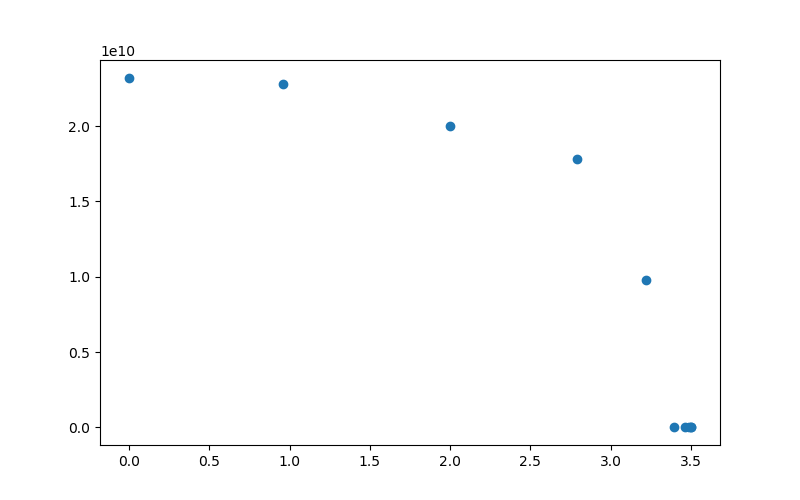

In [281]:
f,ax = plt.subplots(figsize=(8,5))

ax.scatter(z,cumR)

<IPython.core.display.Javascript object>


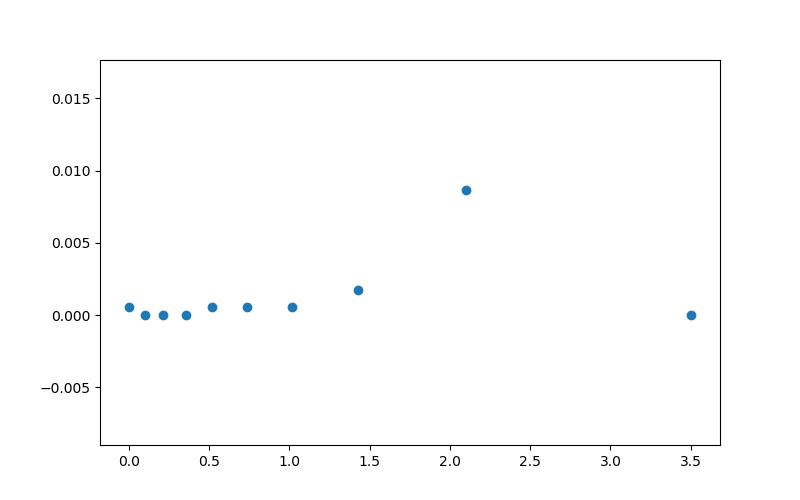

In [229]:
f,ax = plt.subplots(figsize=(8,5))

ax.scatter(z,scrR)